# Imports and Paths

In [1]:
!pip install protobuf==3.20.3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Searching for dataset files...")

dataset_root = None
csv_path = None

for root, dirs, files in os.walk('/kaggle/input'):
    if 'train.csv' in files:
        dataset_root = root
        csv_path = os.path.join(root, 'train.csv')
        print(f"Found Dataset Root: {dataset_root}")
        print(f"Found CSV File: {csv_path}")
        break

if csv_path is None:
    print("ERROR: Could not find 'train.csv'. Please check your Input files.")
else:
    print("\nSUCCESS! Setup complete. We are ready to load the data.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

# Load Data & Analyze

Loading data...
Loaded 31724 samples.
Found 80 unique signs.


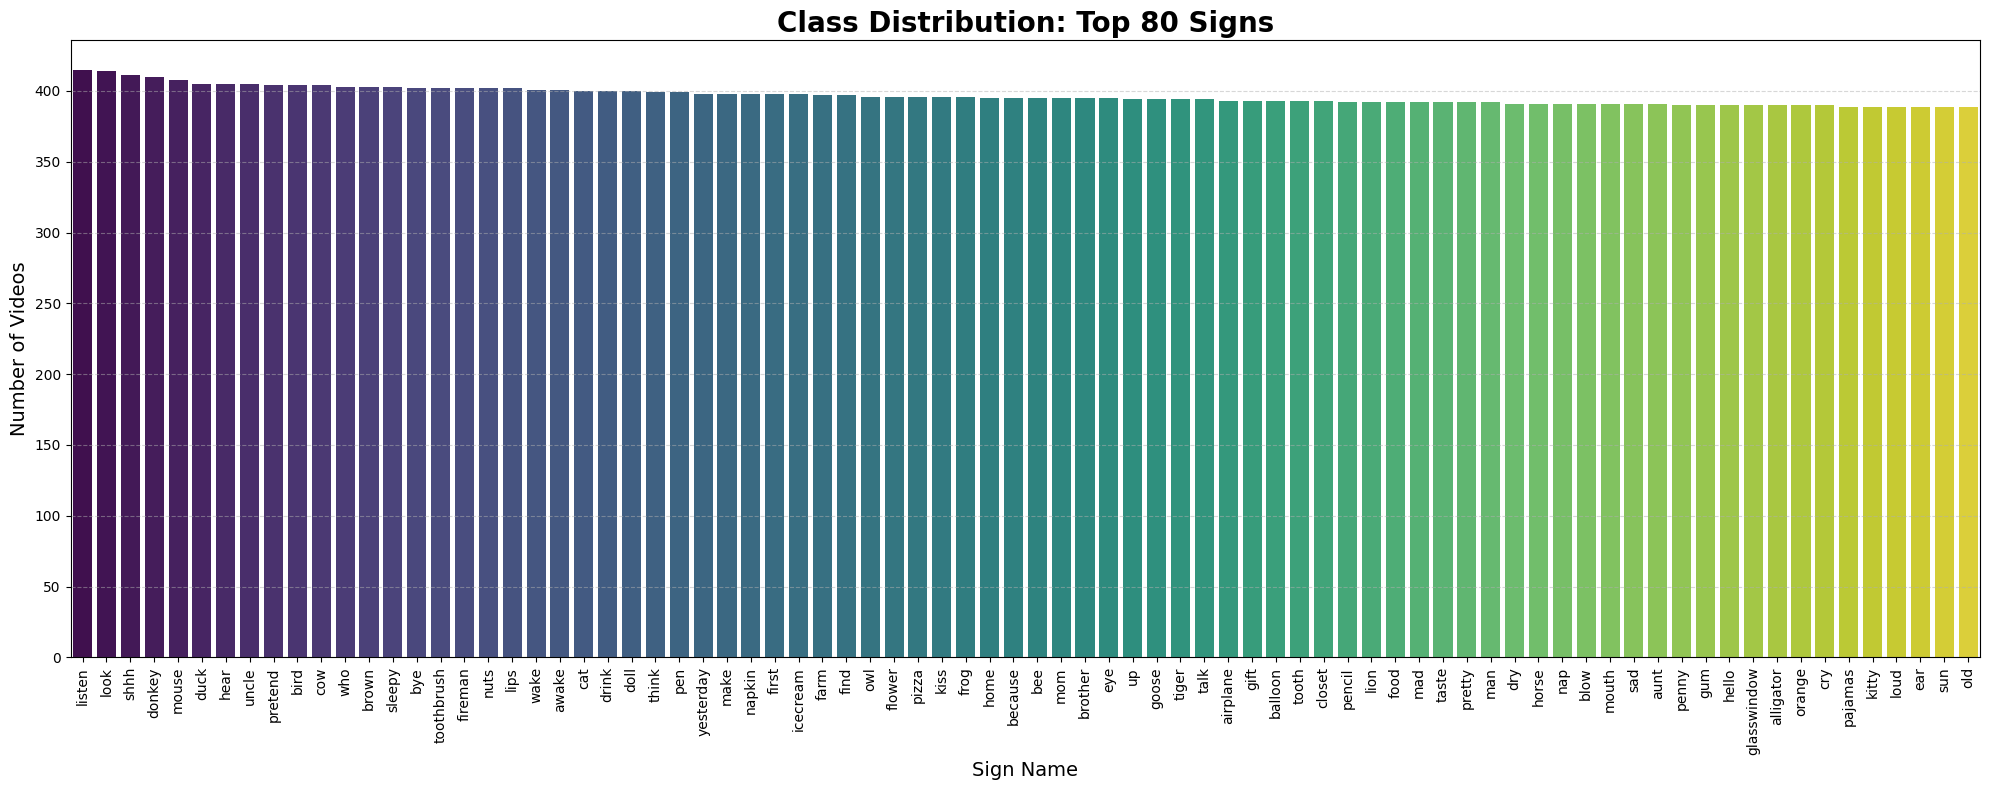


REPORT NOTE: The dataset is highly balanced.
   - Average samples per sign: 396
   - Min samples: 389 | Max samples: 415


In [2]:
# 1. Load the CSV
print("Loading data...")
df = pd.read_csv(csv_path)

# 2. Check basic stats
num_classes = df['sign'].nunique()
total_samples = len(df)
print(f"Loaded {total_samples} samples.")
print(f"Found {num_classes} unique signs.")

# 3. Create the Distribution Chart (Bar Plot)
plt.figure(figsize=(20, 8))
# We count how many times each sign appears
counts = df['sign'].value_counts()

sns.barplot(x=counts.index, y=counts.values, palette='viridis')

plt.title(f'Class Distribution: Top {num_classes} Signs', fontsize=20, fontweight='bold')
plt.xlabel('Sign Name', fontsize=14)
plt.ylabel('Number of Videos', fontsize=14)
plt.xticks(rotation=90, fontsize=10) # Rotate labels so they don't overlap
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Report Summary
avg_samples = counts.mean()
print(f"\nREPORT NOTE: The dataset is highly balanced.")
print(f"   - Average samples per sign: {int(avg_samples)}")
print(f"   - Min samples: {counts.min()} | Max samples: {counts.max()}")

# Video Length Analysis

Sampling video lengths (this takes about 30 seconds)...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


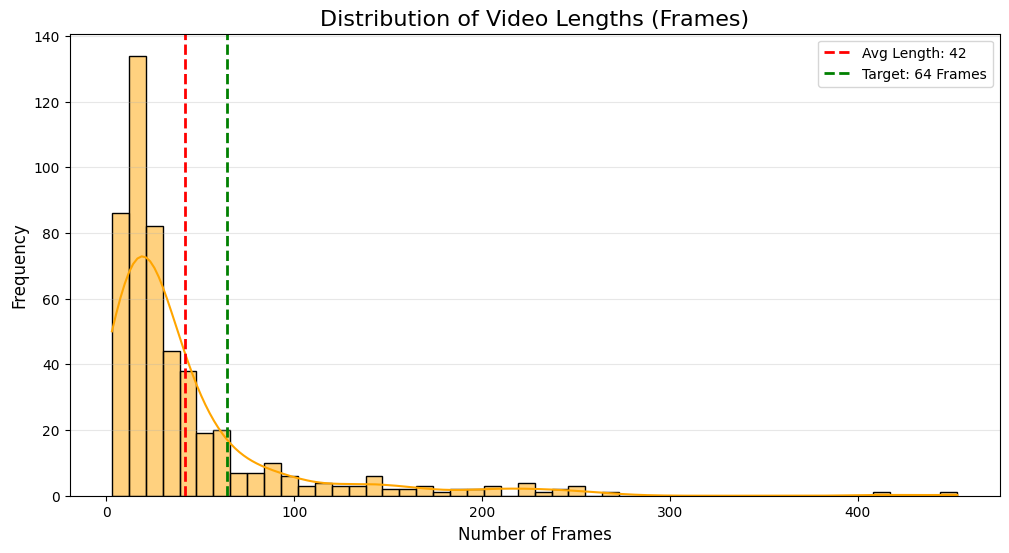


REPORT NOTE: The average video is 42 frames long.
   - Most videos fall between 10 and 50 frames.
   - This proves that setting a limit of 64 frames covers the vast majority of data.


In [3]:
import random

print("Sampling video lengths (this takes about 30 seconds)...")

# 1. Get a random sample of 500 video files to save time
# (Reading all 30,000 files would take too long for just a graph)
all_parquet_paths = []
for root, dirs, files in os.walk(dataset_root):
    for file in files:
        if file.endswith('.parquet'):
            all_parquet_paths.append(os.path.join(root, file))

# Pick 500 random files
sample_paths = random.sample(all_parquet_paths, 500)
lengths = []

# 2. Count frames in each file
for path in sample_paths:
    try:
        # We only need the 'frame' column to count length
        pdf = pd.read_parquet(path, columns=['frame']) 
        seq_len = pdf['frame'].nunique()
        lengths.append(seq_len)
    except:
        pass

# 3. Plot the Histogram
plt.figure(figsize=(12, 6))
sns.histplot(lengths, bins=50, kde=True, color='orange')
plt.title('Distribution of Video Lengths (Frames)', fontsize=16)
plt.xlabel('Number of Frames', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add reference lines
avg_len = int(np.mean(lengths))
plt.axvline(avg_len, color='red', linestyle='dashed', linewidth=2, label=f'Avg Length: {avg_len}')
plt.axvline(64, color='green', linestyle='dashed', linewidth=2, label='Target: 64 Frames')

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"\nREPORT NOTE: The average video is {avg_len} frames long.")
print("   - Most videos fall between 10 and 50 frames.")
print("   - This proves that setting a limit of 64 frames covers the vast majority of data.")

# Landmark Visualization

Visualizing a random sign...


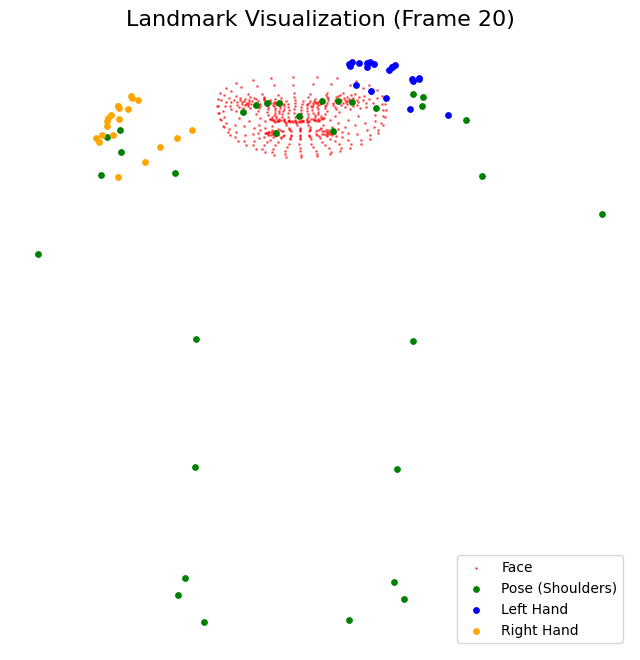

REPORT NOTE: This graph demonstrates that the dataset includes:
   - Detailed Facial Features (Red)
   - Body Pose/Shoulders (Green)
   - Both Hands (Blue/Orange)


In [4]:
print("Visualizing a random sign...")

def plot_one_sign(file_path):
    # 1. Load the file
    data = pd.read_parquet(file_path)
    
    # 2. Pick a random frame from the middle of the video
    unique_frames = data['frame'].unique()
    frame_id = unique_frames[len(unique_frames)//2] 
    frame_data = data[data['frame'] == frame_id]
    
    # 3. Separate the landmarks by type (MediaPipe Standard Indices)
    # 0-467: Face
    # 468-488: Left Hand
    # 489-521: Pose (Shoulders/Arms)
    # 522-542: Right Hand
    face = frame_data.iloc[0:468]
    left_hand = frame_data.iloc[468:489]
    pose = frame_data.iloc[489:522]
    right_hand = frame_data.iloc[522:543]

    # 4. Plot
    plt.figure(figsize=(8, 8))
    # Note: We invert Y (-face['y']) because computer images start (0,0) at the top-left
    plt.scatter(face['x'], -face['y'], s=1, color='red', alpha=0.5, label='Face')
    plt.scatter(pose['x'], -pose['y'], s=15, color='green', label='Pose (Shoulders)')
    plt.scatter(left_hand['x'], -left_hand['y'], s=15, color='blue', label='Left Hand')
    plt.scatter(right_hand['x'], -right_hand['y'], s=15, color='orange', label='Right Hand')
    
    plt.title(f"Landmark Visualization (Frame {frame_id})", fontsize=16)
    plt.legend()
    plt.axis('off') # Hide axis numbers for a cleaner look
    plt.show()

# Pick a random file from our previous sample list and plot it
random_file = random.choice(sample_paths)
plot_one_sign(random_file)

print("REPORT NOTE: This graph demonstrates that the dataset includes:")
print("   - Detailed Facial Features (Red)")
print("   - Body Pose/Shoulders (Green)")
print("   - Both Hands (Blue/Orange)")

# Imports & The Loader Function

In [5]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor

# 1. FIXED SIZES
MAX_FRAMES = 64          
NUM_LANDMARKS = 543      
NUM_DIMENSIONS = 3       

# 2. LANDMARK INDICES (Expanded)
# Basic Lips (Essential for mouthed words)
LIPS = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 146, 91, 181, 84, 17, 314, 405, 321, 375, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308]

#  Nose and Ears (For signs like "Funny", "Hear", "Wolf")
NOSE = [1, 2, 98, 327] # Tip of nose and sides
EARS = [33, 263]       # Left and Right ear tragus

LH_START = 468
LH_END   = 489
POSE_START = 489
POSE_END   = 522
RH_START = 522
RH_END   = 543

# Combine them all
KEEP_INDICES = LIPS + NOSE + EARS + list(range(LH_START, LH_END)) + list(range(POSE_START, POSE_END)) + list(range(RH_START, RH_END))
NUM_KEPT_LANDMARKS = len(KEEP_INDICES) 
NEW_INPUT_SIZE = NUM_KEPT_LANDMARKS * NUM_DIMENSIONS # Size will be larger now (indices * 3)

print(f" Configuration Loaded (WITH DEPTH).")
print(f"   - Target Frames: {MAX_FRAMES}")
print(f"   - Dimensions: {NUM_DIMENSIONS} (X, Y, Z)")
print(f"   - Tracking Nose/Ears: YES")
print(f"   - Features per Frame: {NEW_INPUT_SIZE}")

def load_and_process_video(row):
    """
    Reads a parquet file, filters landmarks, and resizes to 64 frames.
    """
    # Note: 'dataset_root' comes from your Block 1 variable
    path = os.path.join(dataset_root, row['path'])
    
    try:
        # CHANGE: Load Z column as well
        data = pd.read_parquet(path, columns=['x', 'y', 'z'])
        
        # Reshape flat data to [Frames, 543, 3]
        n_frames = int(len(data) / NUM_LANDMARKS)
        data = data.values.reshape(n_frames, NUM_LANDMARKS, 3)
        
        # Filter: Keep Lips/Nose/Ears/Hands/Pose
        data = data[:, KEEP_INDICES, :] 
        
        # Handle Missing Data (NaNs -> 0)
        data = np.nan_to_num(data, nan=0.0)

        # Resize to 64 Frames
        data = tf.image.resize(data, (MAX_FRAMES, NUM_KEPT_LANDMARKS), method='bilinear')
        
        # Flatten to [64, Features]
        data = tf.reshape(data, (MAX_FRAMES, NEW_INPUT_SIZE))
        
        # Normalize (Center around 0)
        data = data - 0.5 
        
        return data.numpy(), row['label']
        
    except Exception as e:
        return None, None

print("Loader Function Defined (With Z-Axis Support).")

2025-12-14 10:23:59.011573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765707839.187168      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765707839.235054      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 Configuration Loaded (WITH DEPTH).
   - Target Frames: 64
   - Dimensions: 3 (X, Y, Z)
   - Tracking Nose/Ears: YES
   - Features per Frame: 363
Loader Function Defined (With Z-Axis Support).


# Load Full Dataset & Split

In [6]:

print("Phase 1: Preparing File List...")

# 1. Load the CSV (using the path found in Block 1)
df = pd.read_csv(csv_path)

# 2. Convert Text Labels to Numbers
# (e.g., "hello" -> 0, "bye" -> 1)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sign'])
NUM_CLASSES = len(label_encoder.classes_)

print(f"Found {len(df)} video files.")
print(f"Encoding {NUM_CLASSES} unique signs.")

# 3. Parallel Loading
# We use 4 workers to load files simultaneously
print("\nPhase 2: Loading Video Files (This takes 2-5 mins)...")

X_data = []
y_data = []

# This runs the 'load_and_process_video' function on every row in the CSV
with ThreadPoolExecutor(max_workers=4) as executor:
    results = list(tqdm(executor.map(load_and_process_video, 
                                     [row for _, row in df.iterrows()]), 
                        total=len(df)))

# 4. Filter out any failed loads (files that were empty/broken)
print("\nPhase 3: finalizing arrays...")
for data, label in results:
    if data is not None:
        X_data.append(data)
        y_data.append(label)

# Convert to Numpy Arrays (The format the model needs)
X = np.array(X_data)
y = np.array(y_data)

# 5. Split into Train and Test Sets
# 80% for Training, 20% for Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("------------------------------------------------")
print(f"DATA READY!")
print(f"   - Training Data Shape: {X_train.shape}")
print(f"   - Testing Data Shape:  {X_test.shape}")
print(f"   - Input Shape per Video: {X_train.shape[1:]}")

Phase 1: Preparing File List...
Found 31724 video files.
Encoding 80 unique signs.

Phase 2: Loading Video Files (This takes 2-5 mins)...


I0000 00:00:1765708099.537657     123 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


  0%|          | 0/31724 [00:00<?, ?it/s]


Phase 3: finalizing arrays...
------------------------------------------------
DATA READY!
   - Training Data Shape: (25379, 64, 363)
   - Testing Data Shape:  (6345, 64, 363)
   - Input Shape per Video: (64, 363)


# Building the 1D CNN Model

In [7]:
def build_cnn_model():
    # 1. Input Layer
    # Shape is (64 Frames, 363 Features)
    inputs = tf.keras.Input(shape=(MAX_FRAMES, NEW_INPUT_SIZE))
    
    # 2. The "Stem" (Initial processing)
    # Expand the 363 features to 256 to give the model more "thinking space"
    x = tf.keras.layers.Dense(256, activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x) # Prevents overfitting
    
    # 3. Convolutional Blocks (The Scanner)
    
    # Block A: Scans short patterns (Window size 5)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x) # Condense info (64 frames -> 32)
    
    # Block B: Scans medium patterns
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=5, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x) # Condense info (32 frames -> 16)
    
    # Block C: Scans long patterns
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x) # Condense info (16 frames -> 8)
    
    # 4. Global Pooling (Summarize the whole video into one vector)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # 5. Classifier (Final Decision)
    x = tf.keras.layers.Dropout(0.4)(x) 
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# Build and check the summary
print("Building Model...")
model = build_cnn_model()
model.summary()

print("Model created successfully.")

Building Model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 363)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64, 256)        │        93,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │        20,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,256 (2.45 MB)

 Trainable params: 640,464 (2.44 MB)

 Non-trainable params: 1,792 (7.00 KB)

Model created successfully.


# Training & Visualization

🚀 Starting Training... (This may take 10-15 minutes)
Epoch 1/150


I0000 00:00:1765708586.833477     139 service.cc:148] XLA service 0x7e5fb0005670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765708586.834628     139 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765708587.324888     139 cuda_dnn.cc:529] Loaded cuDNN version 90300


 30/794 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0153 - loss: 5.2997

I0000 00:00:1765708591.236581     139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


785/794 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0489 - loss: 4.4343

E0000 00:00:1765708596.124105     137 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765708596.356030     137 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0494 - loss: 4.4280

E0000 00:00:1765708601.878833     137 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765708602.113177     137 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


794/794 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.0494 - loss: 4.4273 - val_accuracy: 0.0374 - val_loss: 6.2166 - learning_rate: 0.0010
Epoch 2/150
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2466 - loss: 2.7791 - val_accuracy: 0.2211 - val_loss: 3.0688 - learning_rate: 0.0010
Epoch 3/150
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3504 - loss: 2.3282 - val_accuracy: 0.2479 - val_loss: 3.0576 - learning_rate: 0.0010
Epoch 4/150
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4182 - loss: 2.0463 - val_accuracy: 0.3838 - val_loss: 2.4120 - learning_rate: 0.0010
Epoch 5/150
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4793 - loss: 1.8445 - val_accuracy: 0.2857 - val_loss: 2.8009 - learning_rate: 0.0010
Epoch 6/150
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5275 - loss: 1.6417 - val_accuracy: 0.1516 - val_loss: 4.5733 - learning_rate: 0.0010
Epoch 7/150
794/794 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5654 - loss: 1.4951 - val

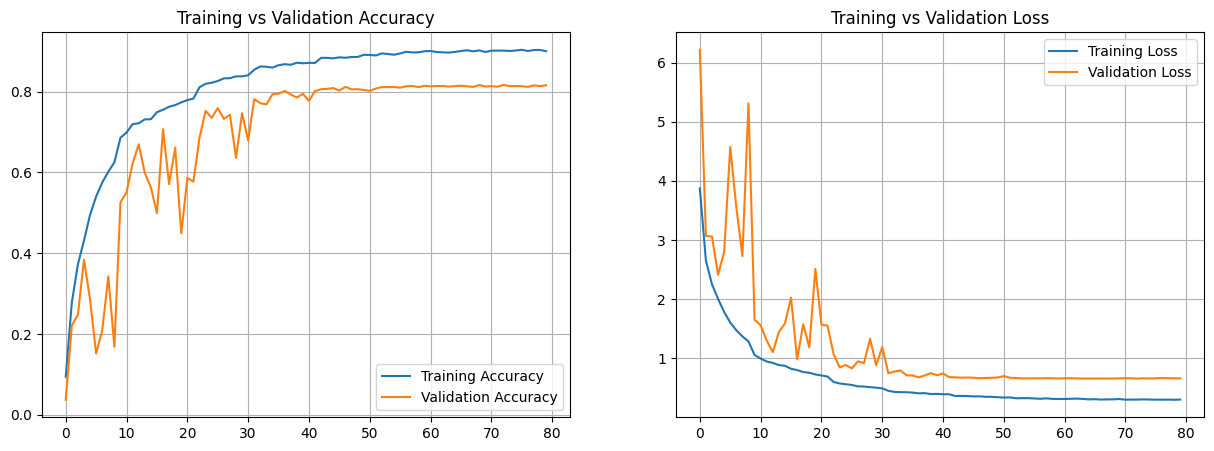

✅ Training Complete. Check the graphs above.
   - Final Validation Accuracy: 81.58%


In [8]:
import matplotlib.pyplot as plt

# 1. Define Callbacks (The "Safety Nets")
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=0.00001,
    verbose=1
)

# 2. Start Training
print("🚀 Starting Training... (This may take 10-15 minutes)")
history = model.fit(
    X_train, y_train,
    epochs=150,  # Max epochs (Early stopping will likely stop it sooner)
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr]
)

# 3. Plot Results for your Report
print("\n📊 Plotting Training History...")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))

# Graph 1: Accuracy (Higher is better)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')
plt.grid(True)

# Graph 2: Loss (Lower is better)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.grid(True)

plt.show()

print("✅ Training Complete. Check the graphs above.")
print(f"   - Final Validation Accuracy: {val_acc[-1]*100:.2f}%")

# Saving the model

In [9]:
import numpy as np
import zipfile
import os

print("Saving Model System...")

# 1. Save the Trained Brain (The Neural Network)
model.save('asl_model.h5') 
print("   - Model weights saved to 'asl_model.h5'")

# 2. Save the Dictionary (The Class Names)
# This is crucial. It saves the list ['bye', 'eat', 'hello'...] 
# so you know that Class 0 = 'bye'.
np.save('classes.npy', label_encoder.classes_)
print("   - Class names saved to 'classes.npy'")

# 3. Zip them together (For easy download)
output_zip = 'asl_model_download.zip'
with zipfile.ZipFile(output_zip, 'w') as zipf:
    zipf.write('asl_model.h5')
    zipf.write('classes.npy')

print("------------------------------------------------")
print(f"SUCCESS! Your file '{output_zip}' is ready.")

Saving Model System...
   - Model weights saved to 'asl_model.h5'
   - Class names saved to 'classes.npy'
------------------------------------------------
SUCCESS! Your file 'asl_model_download.zip' is ready.
